# Integrated Gradients analyses

## Set-up

In [ ]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from feature_importance import IntegratedGradientsBERT#, IntegratedGradientsLSTM

In [ ]:
src_dirname = os.path.join("..", "ig-bert-results")

In [ ]:
plt.style.use('/Users/cgpotts/Documents/research/RMTS/NeuralRelationalReasoning/rmts.mplstyle')

## Analysis functions

In [ ]:
# pos = ['Subj_Q_Neg', 'Subj_Q', 'Subj_Adj', 'Subj_N',
#        'Aux', 'Neg',
#        'Adv', 'V',
#        'Obj_Q_Neg', 'Obj_Q', 'Obj_Adj', 'Obj_N']

pos = ['Neg', 'Q', 'Adj', 'N',
       'Aux', 'Neg',
       'Adv', 'V',
       'Neg', 'Q', 'Adj', 'N']

positions = ['[CLS]']
#positions += [f'prem_{x}' for x in pos]
positions += pos
positions += ['[SEP]']
#positions += [f'hyp_{x}' for x in pos]
positions += pos
positions += ['[SEP]']

pos_map = dict(zip(range(len(positions)), positions))

In [ ]:
def load_data(src_basename, src_dirname=src_dirname):
    src_filename = os.path.join(src_dirname, src_basename)
    with open(src_filename) as f:
        data = json.load(f)
    return data

In [ ]:
def visualize(data, n=5):
    IntegratedGradientsBERT.visualize(data[: n])

In [ ]:
def class_distribution(data):
    return pd.Series([d['true_class'] for d in data]).value_counts()

In [ ]:
def token_level_frame(data):
    tok_df = []
    for d in data:
        toks = d['raw_input']
        scores = d['word_attributions']
        for i, (tok, score) in enumerate(zip(toks, scores)):
            tok_df.append({
                'token': tok,
                'position': i,
                'ling_position': pos_map[i],
                'score': score,
                'true_class': d['true_class'],
                'pred_class': d['pred_class']
            })
    return pd.DataFrame(tok_df)

In [ ]:
def tok_means(tok_df):
    return tok_df.groupby('token').apply(lambda x: x['score'].mean())

In [ ]:
def tok_means_by_class(tok_df):
    return tok_df.groupby('token').apply(
        lambda x: x.groupby('true_class').apply(lambda x: x['score'].mean()))

In [ ]:
def pos_means(tok_df, correct_only=True):
    if correct_only:
        tok_df = tok_df[tok_df['true_class'] == tok_df['pred_class']]
    mu = tok_df.groupby(['position', 'ling_position']).apply(lambda x: x['score'].mean())
    return mu#.sort_values(ascending=False)

In [ ]:
def pos_means_comparative_viz(*pos_dfs, colnames, correct_only=True, output_filename=None):
    df = pd.concat(pos_dfs, axis=1)
    df.columns = colnames
    df = df.sort_index(0, ascending=False).droplevel('position')
    ax = df.plot.barh(figsize=(8, 14))
    ax.set_ylabel("")
    ax.set_xlabel("Mean importance")
    if output_filename:
        plt.savefig(output_filename, dpi=200)

In [ ]:
def diff_cmp(data):
    all_diffs = []
    for d in data:
        toks = d['raw_input']
        scores = d['word_attributions']
        sep_index = toks.index('[SEP]')
        prem = toks[1: sep_index]
        hyp =  toks[sep_index+1: -1]
        assert len(prem) == len(hyp)
        diffs = []
        for i, (p, h) in enumerate(zip(prem, hyp), start=1):
            if p != h:
                diffs.append({
                    'prem_tok': p,
                    'hyp_tok': h,
                    'prem_index': i,
                    'prem_ling_pos': positions[i],
                    'prem_imp': scores[i],
                    'hyp_index': i, # + sep_index,
                    'hyp_ling_pos': positions[i + sep_index],
                    'hyp_imp': scores[i + sep_index]})
        these_data = {'example': d, 'diffs': diffs}
        all_diffs.append(these_data)
    return all_diffs

In [ ]:
def diff_cmp_viz(data, premise=True, output_filename=None):
    cat = 'prem_imp' if premise else 'hyp_imp'
    title = "Premise" if premise else "Hypothesis"
    all_diffs = diff_cmp(data)
    singles = [ex for ex in all_diffs if len(ex['diffs']) == 1]
    flat_singles = []
    for ex in singles:
        d = ex['diffs'][0]
        d['pred_class'] = ex['example']['pred_class']
        flat_singles.append(d)
    sing_df = pd.DataFrame(flat_singles)
    ax = sing_df.boxplot(cat, 'pred_class', figsize=(9, 8), notch=True)
    ax.set_xlabel("")
    ax.set_ylabel("Importance")
    _ = plt.suptitle("")
    _ = plt.title(title)
    if output_filename:
        plt.savefig(output_filename, dpi=200)

## Analyses

In [ ]:
easy_emb = load_data("ig-bert-easy-emb-10k.json")

easy_emb_df = token_level_frame(easy_emb)

In [ ]:
hard_emb = load_data("ig-bert-hard-emb-10k.json")

hard_emb_df = token_level_frame(hard_emb)

In [ ]:
easy_emb_pos = pos_means(easy_emb_df)

In [ ]:
hard_emb_pos = pos_means(hard_emb_df)

In [ ]:
pos_means_comparative_viz(
    easy_emb_pos, hard_emb_pos,
    colnames=['easy', 'hard'],
    output_filename='../pos_emb_easy_hard.png')

In [ ]:
easy_11 = load_data("ig-bert-easy-layer11-10k.json")

easy_11_df = token_level_frame(easy_11)

In [ ]:
hard_11 = load_data("ig-bert-hard-layer11-10k.json")

hard_11_df = token_level_frame(hard_11)

In [ ]:
easy_11_pos = pos_means(easy_11_df)

In [ ]:
hard_11_pos = pos_means(hard_11_df)

In [ ]:
pos_means_comparative_viz(
    easy_11_pos, hard_11_pos,
    colnames=['easy', 'hard'],
    output_filename='../pos_layer11_easy_hard.png')

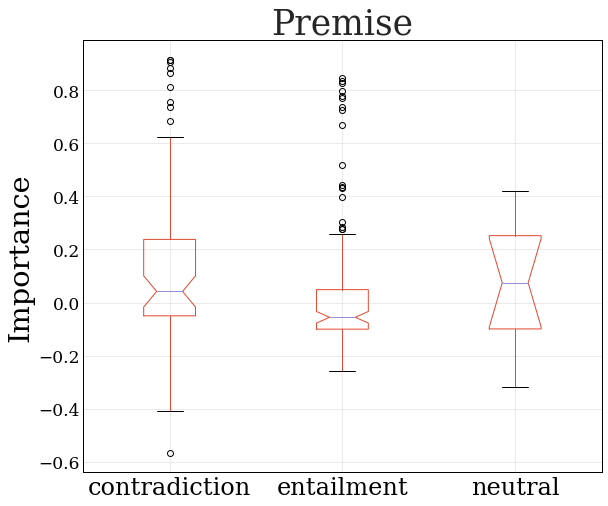

In [416]:
diff_cmp_viz(easy_emb, premise=True, output_filename='../singlediff-easy-premise.png')

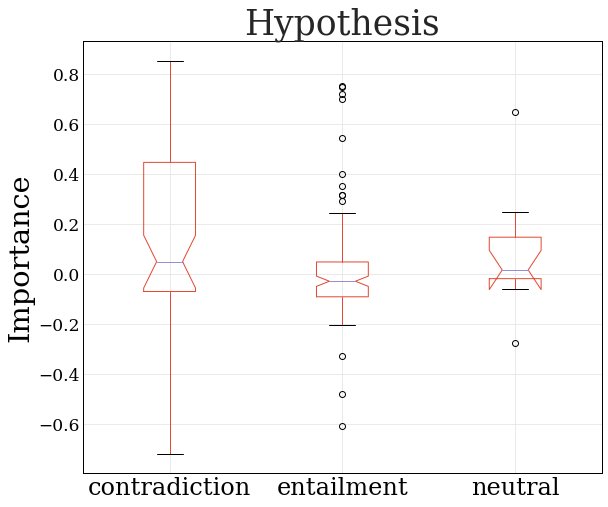

In [417]:
diff_cmp_viz(easy_emb, premise=False, output_filename='../singlediff-easy-hypothesis.png')

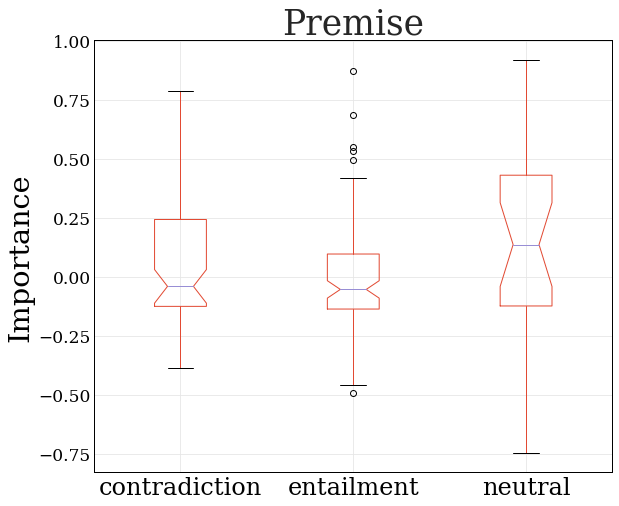

In [419]:
diff_cmp_viz(hard_emb, premise=True, output_filename='../singlediff-hard-premise.png')

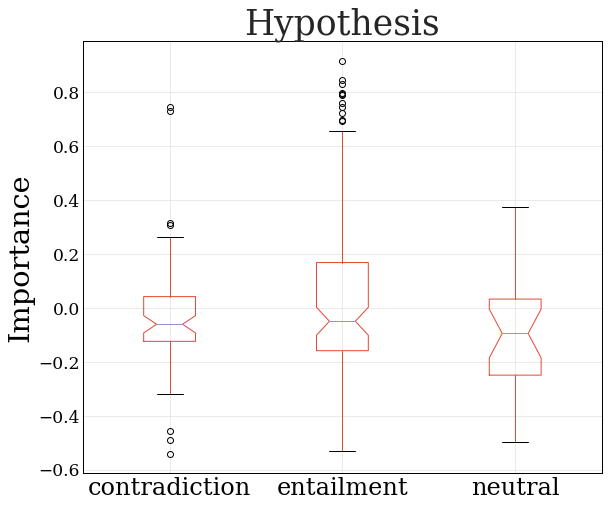

In [418]:
diff_cmp_viz(hard_emb, premise=False, output_filename='../singlediff-hard-hypothesis.png')